In [82]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quilt
from quilt.data.elijahc import ripc

from sklearn.manifold import TSNE

import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Span

In [8]:
pop_df = ripc.population_fc_stats()
pop_df = pop_df.dropna()
pop_df.tail()

,min,Molecular_Weight,log2fc_mean,log2fc_var,p-value
726485,60,268.20519,0.094736,0.812804,0.569362
726486,60,190.17731,-0.092935,0.587453,0.511858
726487,60,150.14178,-0.099776,1.926829,0.696683
726488,60,568.38420,-0.024295,0.092641,0.665231
726489,60,268.20540,-0.367258,0.681297,0.021178


## Extract compounds that have statistically significant p-values at all timepoints after 10min

In [35]:
timepoint_dfs = []
for t in [10,20,30,45,60]:
    t_df = pop_df.query("min == {}".format(t))
    timepoint_dfs.append(t_df[t_df['p-value'] <= 0.001])
tp_mol_w_dfs = [np.unique(df['Molecular_Weight'].values) for df in timepoint_dfs]

In [36]:
# Keep only compounts that appear in all 5 timepoints
u_idx = tp_mol_w_dfs[-1]
for arr in tp_mol_w_dfs[-2::-1]:
    u_idx = np.intersect1d(u_idx,arr)
print(len(u_idx))

2294


In [38]:
def set_filter(df,column,criteria):
    return df[df[column].isin(criteria)]

In [39]:
pop_df_short = set_filter(pop_df,'Molecular_Weight',u_idx)

In [62]:
comp_ts_profile = pop_df_short.pivot_table(columns='min',index='Molecular_Weight',values='log2fc_mean')

In [64]:
X = comp_ts_profile.values

In [74]:
X_embedded = TSNE(n_components=2,verbose=1,n_iter=5000).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2294 samples in 0.002s...
[t-SNE] Computed neighbors for 2294 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2294
[t-SNE] Computed conditional probabilities for sample 2000 / 2294
[t-SNE] Computed conditional probabilities for sample 2294 / 2294
[t-SNE] Mean sigma: 0.061972
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.663498
[t-SNE] Error after 5000 iterations: 1.104335


In [80]:
tsne_df = pd.DataFrame(X_embedded,index=comp_ts_profile.index,columns=['tsne_1','tsne_2']).reset_index()

In [81]:
tsne_df.head()

,Molecular_Weight,tsne_1,tsne_2
0,66.98955,50.720161,14.379823
1,67.98743,-5.033978,-35.750240
2,68.06219,2.050528,-32.525917
3,68.06271,-70.302742,-11.557899
4,68.06391,-72.218216,17.647051


In [91]:
from bokeh.palettes import Plasma256
from bokeh.transform import log_cmap
from bokeh.models import LassoSelectTool

mapper = log_cmap(field_name='Molecular_Weight', palette=Plasma256 ,low=min(tsne_df['Molecular_Weight'].values) ,high=max(tsne_df['Molecular_Weight'].values))

def plot_tsne(x,y,hue=None,data=None,tools='hover,save,reset,pan,lasso_select',**kwargs):
    X_vals = data[x]
    Y_vals = data[y]
    source = ColumnDataSource(data)
    p = bp.figure(tools=tools, x_range=(min(X_vals),max(X_vals)), y_range=(min(Y_vals),max(Y_vals)))
    p.hover.tooltips = [
        ("Molecular Weight", "@{Molecular_Weight}"),
    ]
    p.circle(x,y, line_color=hue, color=hue, size=5,source=source)
    
    def selection_change(attrname, old, new):
        selected = source.selected.indices
    
        if selected:
            print(selected)

    source.on_change('selected', selection_change)
    
    return p


In [92]:
bp.output_notebook()
p = plot_tsne('tsne_1','tsne_2',hue=mapper,data=tsne_df)
bp.show(p)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



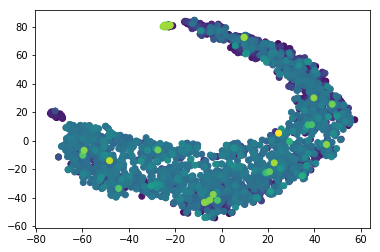

In [75]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=comp_ts_profile.index.values)